# Roy's testing app

In [1]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import pandas as pd
import numpy as np
import utils
import os
from utils import PROJECT_ROOT, DATA_PATH
import yuval_module.paper_source as PaperSource

import py_4.get_mesh_vec as get_mesh_vec
import py_3.sim_matrix_3 as sim_matrix_3
import py_4.get_all_features as get_all_features 

from torch.utils.data import Dataset, DataLoader

%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import *


In [3]:
current_dir = Path.cwd()
home_dir = Path.home()
print(current_dir)
print(home_dir)

/Users/roygranit/Desktop/ydata/industry_project/repo/academix-ydata-project/code
/Users/roygranit


In [4]:
FILE = "enriched_labeled_dataset_large.json" 
if os.path.exists(PROJECT_ROOT + DATA_PATH + FILE):
    print("READING FROM LOCAL")
    if FILE.split(".")[1] == "json":
        df = pd.read_json(PROJECT_ROOT + DATA_PATH + FILE)
    else:
        df = pd.read_csv(PROJECT_ROOT + DATA_PATH + FILE)
    #ps = PaperSource()
else:
    print("PULLING FROM S3")
    ps = sim_matrix_3.load_dataset(FILE)
    df = ps.get_dataset()

df.drop(columns=["last_author_country"],inplace=True)
df.rename(columns={'ORG_STATE':'last_author_country'},inplace=True)

print("FILE PULLED")

READING FROM LOCAL
FILE PULLED


# Explore mesh

In [6]:
df.head(2)

,pmid,last_author_country,PI_IDS,last_author_name,authors,doi,journal_name,language,last_author,last_author_email,last_author_id,last_author_inst,mesh,mesh_major,pub_year,title
0,19810465,PA,8352708,"Madabhushi, A","[{'forename': 'Pallavi', 'affiliation': 'Depar...",None,Medical physics,eng,None,None,2517051.0,None,"[Humans, Linear Models, Male, Pilot Projects, ...","[Algorithms, Cluster Analysis, Diagnosis, Comp...",2009.0,A hierarchical spectral clustering and nonline...
1,26167385,PA,8352708,"Madabhushi, A","[{'forename': 'Akshay', 'affiliation': 'Depart...",None,Journal of pathology informatics,eng,{'affiliation': 'Department of Biomedical Engi...,None,NaN,"Rutgers, The State University of New Jersey",None,None,2015.0,Content-based image retrieval of digitized his...


In [7]:
me=get_mesh_vec.MeshEmbeddings()

In [8]:
all_mesh=set() 
for mm in df[:30000]['mesh'].to_list():
    try:
        for m in mm:
           # print(m)
            all_mesh.add(m)
    except:
        pass
print(len(all_mesh))

32823


In [9]:
me.set_mesh_freq(list(all_mesh))

In [10]:
df2=df[:10000]
df2=df2.dropna(subset=['mesh']).reset_index()
df2['vec']=df2['mesh'].apply(lambda x: me.get_mesh_emb(x)[0])

In [11]:
df2.head(2)

,index,pmid,last_author_country,PI_IDS,last_author_name,authors,doi,journal_name,language,last_author,last_author_email,last_author_id,last_author_inst,mesh,mesh_major,pub_year,title,vec
0,0,19810465,PA,8352708,"Madabhushi, A","[{'forename': 'Pallavi', 'affiliation': 'Depar...",None,Medical physics,eng,None,None,2517051.0,None,"[Humans, Linear Models, Male, Pilot Projects, ...","[Algorithms, Cluster Analysis, Diagnosis, Comp...",2009.0,A hierarchical spectral clustering and nonline...,"[29.13949110878572, 39.9266187284969, 39.35088..."
1,3,25958195,PA,8352708,"Madabhushi, A","[{'forename': 'Jun', 'affiliation': 'Jiangsu K...",10.1016/j.compmedimag.2015.04.002,Computerized medical imaging and graphics : th...,eng,{'affiliation': 'Department of Biomedical Engi...,None,1576937.0,Case Western Reserve University,"[Coloring Agents, Female, Humans, Models, Stat...","[Algorithms, Breast/pathology, Color, Image En...",2015.0,Sparse Non-negative Matrix Factorization (SNMF...,"[20.78959039746426, 16.97823482755982, 5.31089..."


In [16]:
X=df2.vec.to_list()
ids=df2.index.to_list()
X[0]

array([ 29.13949111,  39.92661873,  39.35088718,   0.12615154,
        21.56074102,   8.71754868, -21.21081918,  18.47010033,
       -39.54505848, -54.06960271,  25.87834466,  19.16984295,
        21.32953834,  36.98004787, -12.56056136,  -0.87229909,
        54.24082836,  27.7439268 , -22.10145443, -63.39352139,
        -3.18082552,  -5.94109105,  -2.3948647 ,  -4.82997672,
        32.57842848,   2.54820518,   7.31662033,   5.21720816,
        26.6369901 ,  47.97403249,  41.23356382,  21.74053248,
         3.22307615,   7.21328422,  -3.98735092,  49.11359511,
        13.07235776,  25.17407187, -17.82834916,  35.19943614,
        18.94347961, -16.67326448,  -2.62297873, -21.94679025,
       -55.42745706, -55.31659393,  45.51696778,  16.25974672,
       -10.89999553, -18.77786031, -65.34674194, -19.55726546,
        18.49505464, -49.1489508 , -32.46926649,  -4.24551345,
       -37.46968165, -27.30925795,  14.80077169, -15.67037135,
       -55.60852515,  13.20683177,  21.80382753, -39.02

In [17]:
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.neighbors import NearestNeighbors


In [18]:
#X=[[1,2,3],[4,5,6],[7,6,7]]

In [19]:
dist_matrix=euclidean_distances(X, X)
dist_matrix

array([[0.00000000e+00, 1.72509626e+02, 1.22562233e+02, ...,
        3.28578726e+02, 2.89234747e+02, 3.37782183e+02],
       [1.72509626e+02, 0.00000000e+00, 9.35952608e+01, ...,
        3.07235273e+02, 2.71045752e+02, 3.37543523e+02],
       [1.22562233e+02, 9.35952608e+01, 0.00000000e+00, ...,
        3.13706893e+02, 2.76305516e+02, 3.48770533e+02],
       ...,
       [3.28578726e+02, 3.07235273e+02, 3.13706893e+02, ...,
        0.00000000e+00, 1.99437554e+02, 3.01290008e+02],
       [2.89234747e+02, 2.71045752e+02, 2.76305516e+02, ...,
        1.99437554e+02, 9.34406182e-06, 2.93409341e+02],
       [3.37782183e+02, 3.37543523e+02, 3.48770533e+02, ...,
        3.01290008e+02, 2.93409341e+02, 7.62939453e-06]])

In [20]:
dist_matrix.shape

(8532, 8532)

In [23]:
ind = np.unravel_index(np.argmax(dist_matrix, axis=None), dist_matrix.shape)  # returns a tuple
ind

(7972, 8210)

In [24]:
dist_matrix[ind[0]][ind[1]]

1052.4606518672608

In [25]:
ids[ind[0]], ids[ind[1]]

(7972, 8210)

In [68]:
df3=df2.iloc[[7972, 8210]][['pmid','mesh']]
df3.mesh.to_list()

[['Amygdala/metabolism',
  'Animals',
  'Base Sequence',
  'Behavior, Animal/physiology',
  'Drosophila melanogaster/genetics',
  'Female',
  'Gene Deletion',
  'Locomotion/genetics',
  'Male',
  'Mice',
  'Mice, Inbred AKR',
  'Mice, Inbred BALB C',
  'Mice, Inbred C3H',
  'Mice, Inbred C57BL',
  'Mice, Inbred DBA',
  'Mice, Transgenic',
  'Sequence Analysis, DNA',
  'Sex Factors',
  'Sleep/genetics',
  'Suprachiasmatic Nucleus/metabolism',
  'Vestibular Function Tests'],
 ['Adolescent',
  'Adult',
  'Aged',
  'Aged, 80 and over',
  'Child',
  'Child, Preschool',
  'Female',
  'Gene Expression Regulation, Enzymologic/drug effects',
  'Genotype',
  'Humans',
  'Infant',
  'Infant, Newborn',
  'Male',
  'Middle Aged',
  'NADPH-Ferrihemoprotein Reductase/metabolism',
  'Nicotine/pharmacology',
  'Oxidoreductases/genetics',
  'RNA, Messenger/genetics',
  'Umbelliferones/pharmacology',
  'Young Adult']]

In [27]:
X_ = np.array(X)

In [28]:
nbrs = NearestNeighbors(n_neighbors=100, algorithm='auto').fit(X)
distances, indices = nbrs.kneighbors(X)
indices

array([[   0, 1812, 3019, ..., 4074, 7000, 1808],
       [   1, 4534,  777, ..., 3812, 4253,  653],
       [   2,  936, 8290, ..., 7702, 3418, 2015],
       ...,
       [8529, 1232, 4469, ..., 7464, 1116, 8413],
       [8530, 5206, 5006, ..., 2211, 2567, 1216],
       [8531, 1055, 5049, ..., 2651, 5459, 7556]])

In [251]:
indices[7972]#7972, 8210

array([7972, 4267,  978, 8353, 8078, 7654, 6681, 8387, 1732, 5972, 7857,
         68, 7855, 3475,  281, 7693, 7327, 7291, 2296, 3169,  972, 4168,
       7068, 6515, 7292, 5209, 8081, 7467, 6362, 6822, 4980, 5434, 7648,
       3898, 6195, 1119, 5036, 5013, 3051, 7228, 4721, 7516, 6112, 7528,
       5645, 5677, 7860, 8090, 6033, 5320, 3171, 4019, 3468, 1002, 3939,
       4986, 4046, 7312, 7123, 8015, 7126, 2398, 6848, 2005, 5211, 6850,
       5185, 6811, 3596, 3114, 4765, 2310, 3134, 4038, 8361, 5978, 6595,
       8246, 5962, 4048, 8188, 3305, 7193, 6081, 7616, 4532, 7100, 6847,
       6844, 6839,  536, 6084, 4192, 7701, 1192, 7309, 6723,  561, 1782,
       1961])

In [29]:
group_A=df2.iloc[indices[7972]].pmid.to_list()
group_B=df2.iloc[indices[8210]].pmid.to_list()

In [262]:
pd.DataFrame({'A': group_B, 'B' :group_A}).to_csv('mesh_paper_groups_pmid.csv')



In [30]:
list_df=pd.DataFrame({'A': group_B, 'B' :group_A})
list_df


,A,B
0,27815364,26131556
1,28624066,29218900
2,26556772,26900925
3,29309592,18845632
4,24737801,27933336
...,...,...
95,26499807,18987328
96,26669971,26164072
97,19085212,24561662
98,26476637,29046480


In [52]:
A=np.array(df2[df2['pmid'].isin(list_df.A.to_list())].vec.to_list())
B=np.array(df2[df2['pmid'].isin(list_df.B.to_list())].vec.to_list())

In [54]:
C=np.concatenate((A,B),axis=0)
C.shape

(200, 64)

In [23]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

In [59]:
df_pcd=pd.DataFrame()
pca = PCA(n_components=2)
pca_result = pca.fit_transform(C)
df_pcd['pca-one'] = pca_result[:,0]
df_pcd['pca-two'] = pca_result[:,1] 
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))


Explained variation per principal component: [0.72769612 0.05168091]


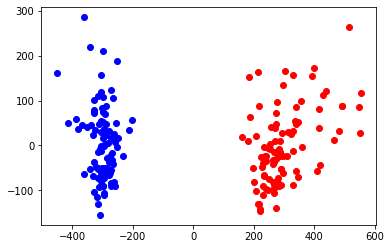

In [67]:
plt.scatter(df_pcd['pca-one'][:100],df_pcd['pca-two'][:100],color ='red')
plt.scatter(df_pcd['pca-one'][100:],df_pcd['pca-two'][100:],color ='blue')

# Co-authors


In [6]:
import py_4.get_all_features as get_all_features

In [7]:
df2=df[:10000]
df2=df2.dropna(subset=['authors']).reset_index()


In [11]:
feat=get_all_features.VAE_Features(df2)

'/Users/roygranit/Desktop/ydata/industry_project/repo/academix-ydata-project/code/models/names_epochs_2_vectorSize_64_window_2.model' already exits. Using existing model to re-generate results.
'/Users/roygranit/Desktop/ydata/industry_project/repo/academix-ydata-project/code/models/co_authors_epochs_2_vectorSize_64_window_2.model' already exits. Using existing model to re-generate results.


In [13]:
coa_vectors=feat.get_co_authors_features(df2)
coa_vectors.shape

(10000, 65)

In [15]:
X=coa_vectors

In [18]:
dist_matrix=euclidean_distances(X, X)
dist_matrix

array([[ 0.        ,  0.04169237,  1.00154897, ..., 16.00008088,
         9.00013984,  6.00019619],
       [ 0.04169237,  0.        ,  1.00152789, ..., 16.00007199,
         9.00014406,  6.00023976],
       [ 1.00154897,  1.00152789,  0.        , ..., 15.0000854 ,
         8.00014739,  5.00029375],
       ...,
       [16.00008088, 16.00007199, 15.0000854 , ...,  0.        ,
         7.0002048 , 10.00015386],
       [ 9.00013984,  9.00014406,  8.00014739, ...,  7.0002048 ,
         0.        ,  3.00038228],
       [ 6.00019619,  6.00023976,  5.00029375, ..., 10.00015386,
         3.00038228,  0.        ]])

In [19]:
ind = np.unravel_index(np.argmax(dist_matrix, axis=None), dist_matrix.shape)  # returns a tuple
ind

(1736, 5189)

In [32]:
nbrs = NearestNeighbors(n_neighbors=50, algorithm='auto').fit(X)
distances, indices = nbrs.kneighbors(X)
indices

array([[   0, 8409, 7541, ..., 5726, 8038, 9438],
       [   1, 6462, 3972, ..., 6791, 8884, 5122],
       [   2, 9378, 2114, ..., 2057, 2272, 6076],
       ...,
       [9997,  981, 3058, ..., 4815, 2632, 2438],
       [9998, 6341, 2217, ..., 5361, 6345, 1743],
       [9999, 9021,   51, ..., 6282, 1829, 7925]])

In [33]:
group_A=df2.iloc[indices[1736]].pmid.to_list()
group_B=df2.iloc[indices[5189]].pmid.to_list()

In [34]:
list_df=pd.DataFrame({'A': group_B, 'B' :group_A})
list_df


,A,B
0,28714976,25743456
1,25940428,19119179
2,29059683,25753093
3,28443625,28276649
4,25849179,27798498
5,25751625,25227934
6,29446198,29355244
7,27459855,19096787
8,29915430,19448080
9,24943594,19756298


In [35]:
A=X[indices[1736]]
B=X[indices[5189]]

In [36]:
C=np.concatenate((A,B),axis=0)
C.shape

(100, 65)

In [37]:
df_pcd=pd.DataFrame()
pca = PCA(n_components=2)
pca_result = pca.fit_transform(C)
df_pcd['pca-one'] = pca_result[:,0]
df_pcd['pca-two'] = pca_result[:,1] 
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))


Explained variation per principal component: [9.99999847e-01 8.56949344e-09]


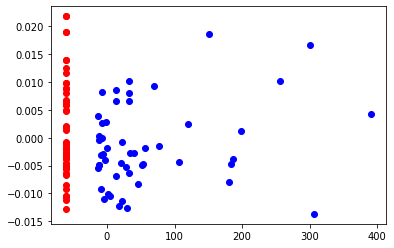

In [39]:
plt.scatter(df_pcd['pca-one'][:50],df_pcd['pca-two'][:50],color ='red')
plt.scatter(df_pcd['pca-one'][50:],df_pcd['pca-two'][50:],color ='blue')

In [41]:
import time

In [42]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(C)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 99 nearest neighbors...
[t-SNE] Indexed 100 samples in 0.001s...
[t-SNE] Computed neighbors for 100 samples in 0.024s...
[t-SNE] Computed conditional probabilities for sample 100 / 100
[t-SNE] Mean sigma: 0.032721
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.346134
[t-SNE] KL divergence after 300 iterations: 0.097730
t-SNE done! Time elapsed: 0.6902279853820801 seconds


In [45]:
df_subset=pd.DataFrame()
df_subset['y']=np.ones(100)
df_subset['y'][:50]
df_subset['y'][:50]=0
df_subset

,y
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
95,1.0
96,1.0
97,1.0
98,1.0


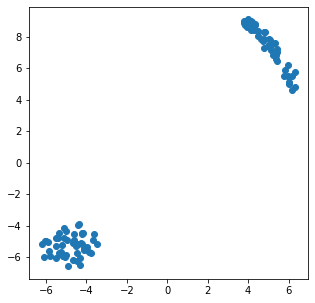

In [51]:
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(5,5))
plt.scatter(df_subset['tsne-2d-one'],df_subset['tsne-2d-two'])

In [6]:
obj=df[:1].authors
for i in obj[0]:
    print(i['name'])

Tiwari, P
Rosen, M
Madabhushi, A


In [10]:
[i['name']for i in obj[0]]

['Tiwari, P', 'Rosen, M', 'Madabhushi, A']

In [7]:
df['names']= df.authors.apply(lambda x: [i['name']for i in x])

In [8]:
df['names']

0                      [Tiwari, P, Rosen, M, Madabhushi, A]
1                     [Sridhar, A, Doyle, S, Madabhushi, A]
2          [Tiwari, P, Danish, SF, Jiang, B, Madabhushi, A]
3         [Xu, J, Xiang, L, Wang, G, Ganesan, S, Feldman...
4            [Basavanhally, A, Viswanath, S, Madabhushi, A]
                                ...                        
196566    [Choudhary, V, Olala, LO, Kaddour-Djebbar, I, ...
196567    [Qureshi, H, Genescà, M, Fritts, L, McChesney,...
196568    [Grummon, AH, Heaney, CA, Dellinger, WA, Wilki...
196569                  [Buck, KJ, Walter, NA, Denmark, DL]
196570    [Braun, LR, Fisk, WA, Lev-Tov, H, Kirsner, RS,...
Name: names, Length: 196571, dtype: object

In [10]:
pd.DataFrame(df['names']).to_pickle('co_authors.pkl')

### TOY DATASET RUN ###

In [182]:
auth_core, auth_eps, auth_usecase = sim_matrix_3.split_authors(pd,df)

#Take five authors from base case
df_core = df[df['last_author_name'].isin(auth_core[:5])]

187
94


In [183]:
selection = auth_core[:5]

In [193]:
class ToyDS(Dataset):
    def __init__(self,df,selection,vae_features = None):
        super().__init__()
        self.df = df[df['last_author_name'].isin(selection)]
        if vae_features is None:
            self.vae_features = get_all_features.VAE_Features(self.df)
        else:
            self.vae_features = vae_features
        self.features = self.vae_features.get_all_features(self.df)
        self.input_dim = self.vae_features.input_dims
            
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, idx):
        features = self.features[idx]
        return features
    
    def __getvae__(self):
        return self.vae_features

In [194]:
train_set = ToyDS(df, selection)
train_loader=DataLoader(dataset= train_set, batch_size = batch_size, shuffle = True, num_workers = num_workers)

MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Female
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Female
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Female
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Female
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Female
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Female
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Female
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Female
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Female
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Female
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Female
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Female
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Female
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Female
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Female
MESH NAM

In [195]:
class VAE(nn.Module):
    def __init__(self, input_dim = train_set.input_dim):
        super(VAE, self).__init__()
        self.input_dim = input_dim
        self.fc1 = nn.Linear(self.input_dim, 32)
        self.fc21 = nn.Linear(32, 8)
        self.fc22 = nn.Linear(32, 8)
        self.fc3 = nn.Linear(8, 32)
        self.fc4 = nn.Linear(32, self.input_dim)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, self.input_dim))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar, z

In [196]:
def loss_function(recon_x, x, mu, logvar):
    #BCE = F.binary_cross_entropy(recon_x, x.view(-1, 64), reduction='sum')

    MSE = F.mse_loss(recon_x, x.view(-1, train_set.input_dim))

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return MSE + KLD

In [197]:
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [198]:
from torchsummary import summary
summary(model, (20,train_set.input_dim))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 32]           2,112
            Linear-2                    [-1, 8]             264
            Linear-3                    [-1, 8]             264
            Linear-4                   [-1, 32]             288
            Linear-5                   [-1, 65]           2,145
Total params: 5,073
Trainable params: 5,073
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.02
Estimated Total Size (MB): 0.03
----------------------------------------------------------------


In [190]:
def train_epoch(tr_loader, model, criterion, optimizer, num_epochs):
    model.train()
    train_log = []
    
    for epoch in range(num_epochs):
        bottle_neck=[]
        print("Started training epoch no. {}",format(epoch+1))
        train_loss= 0
        for batch_idx, data in enumerate(train_loader):
            data = data.to(device, dtype=torch.float32)

            optimizer.zero_grad()
            recon_batch, mu, logvar, z = model(data)
            bottle_neck.extend(z.detach().numpy())
            loss = criterion(recon_batch, data, mu, logvar)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
            if batch_idx % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader),
                    loss.item() / len(data)))

        print('====> Epoch: {} Average loss: {:.4f}'.format(
            epoch, train_loss / len(train_loader.dataset)))
        train_log.append({
            'epoch': epoch,
            'train_loss': train_loss / len(train_loader)})
    return train_log, bottle_neck

In [191]:
# def test(epoch):
#     model.eval()
#     test_loss = 0
#     with torch.no_grad():
#         for i, (data, _) in enumerate(test_loader):
#             data = data.to(device)
#             recon_batch, mu, logvar = model(data)
#             test_loss += loss_function(recon_batch, data, mu, logvar).item()
#             if i == 0:
#                 n = min(data.size(0), 8)
#                 comparison = torch.cat([data[:n],
#                                       recon_batch.view(args.batch_size, 1, 28, 28)[:n]])
#                 save_image(comparison.cpu(),
#                          'results/reconstruction_' + str(epoch) + '.png', nrow=n)

#     test_loss /= len(test_loader.dataset)
#     print('====> Test set loss: {:.4f}'.format(test_loss))

In [192]:
train_log, bottle_neck= train_epoch(train_loader,model,loss_function,optimizer,num_epochs= 3)

Started training epoch no. {} 1
Train Epoch: 0 [0/88 (0%)]	Loss: 0.628652
Train Epoch: 0 [80/88 (91%)]	Loss: nan
====> Epoch: 0 Average loss: nan
Started training epoch no. {} 2
Train Epoch: 1 [0/88 (0%)]	Loss: nan
Train Epoch: 1 [80/88 (91%)]	Loss: nan
====> Epoch: 1 Average loss: nan
Started training epoch no. {} 3
Train Epoch: 2 [0/88 (0%)]	Loss: nan
Train Epoch: 2 [80/88 (91%)]	Loss: nan
====> Epoch: 2 Average loss: nan


In [165]:
len(bottle_neck)

72

# Test

In [92]:
test_set = ToyDS(df[df.PI_IDS.isin(selection)])
test_loader=DataLoader(dataset= test_set, batch_size = batch_size, shuffle = True, num_workers = num_workers)

MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Female
MESH NAME NOT FOUND: Female
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Female
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Female
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Female
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Female
MESH NAME NOT FOUND: Female
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Female
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Female
MESH NAME NOT FOUND: Female
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Female
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Female
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Female
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Female
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Male
MESH NAME 

In [93]:
bottle_neck=[]
for batch_idx, (data, _) in enumerate(test_loader):
            data = data.to(device, dtype=torch.float32)
            optimizer.zero_grad()
            recon_batch, mu, logvar, z= model(data)
            bottle_neck.extend(z.detach().numpy())

In [94]:
bottle_neck

[array([-0.6486725 , -0.15034525, -1.0171756 , -0.16950682, -0.22891621,
        -3.270538  , -0.28580105, -0.3674364 ], dtype=float32),
 array([ 0.8835745 , -0.03101728, -0.5089596 , -2.1510155 ,  1.1890123 ,
        -1.3621026 , -0.34572008, -0.83343077], dtype=float32),
 array([-1.1953305 , -0.27174437, -1.4440532 , -0.3045028 ,  1.2823002 ,
        -1.3462763 , -1.3165208 , -0.86988634], dtype=float32),
 array([ 1.7830164 , -0.96988785, -0.9716988 , -1.399534  ,  0.5548248 ,
        -0.45105729, -0.01939731,  0.5986611 ], dtype=float32),
 array([-0.8280789 ,  0.26614776, -0.89590377,  0.8540143 , -0.9096126 ,
        -1.7499075 ,  0.45291007, -0.12698995], dtype=float32),
 array([-0.02145121,  1.1948818 ,  1.2952127 , -1.0339434 , -0.517646  ,
         1.4353939 , -0.656565  ,  0.2335705 ], dtype=float32),
 array([ 0.7585333 ,  0.45156795,  1.1655523 ,  0.32099745,  1.328476  ,
        -0.7823271 ,  0.98038334, -0.4957803 ], dtype=float32),
 array([-0.7761407 , -3.0280778 ,  0.7230

In [95]:
from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import time


In [102]:
ds=np.array(bottle_neck)
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=1, n_iter=300)
tsne_results = tsne.fit_transform(ds)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 4 nearest neighbors...
[t-SNE] Indexed 72 samples in 0.000s...
[t-SNE] Computed neighbors for 72 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 72 / 72
[t-SNE] Mean sigma: 0.229830
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.891182
[t-SNE] KL divergence after 300 iterations: 2.995824
t-SNE done! Time elapsed: 0.09877514839172363 seconds


In [103]:
df_subset=pd.DataFrame()
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]
df_subset['PI'] = PI_lst

Text(0, 0.5, 'tsne-2d-one')

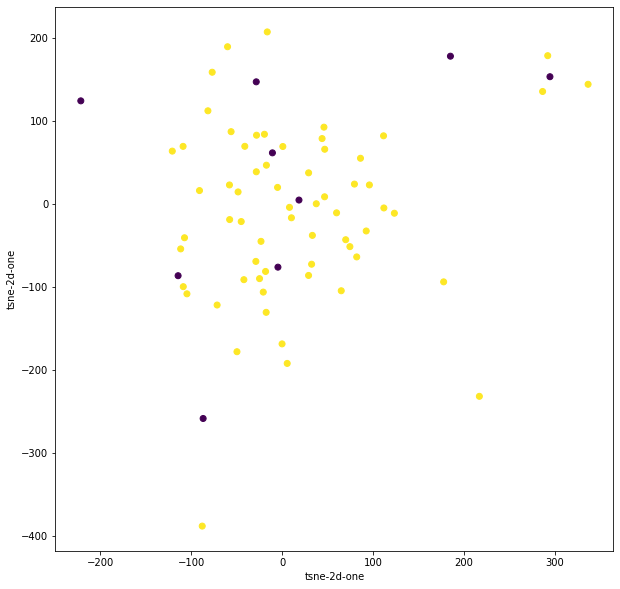

In [104]:
plt.figure(figsize=(10,10))
plt.scatter(df_subset['tsne-2d-one'],df_subset['tsne-2d-two'],c=df_subset['PI'])
plt.xlabel('tsne-2d-one')
plt.ylabel('tsne-2d-one')


In [40]:
tsne_results

array([[-2.2443347 , -4.706242  ],
       [ 4.034638  ,  2.8211336 ],
       [ 1.2392521 , -1.8968908 ],
       ...,
       [-5.816544  , -8.111503  ],
       [-0.77172625, -2.0545878 ],
       [-0.9246067 , -5.730704  ]], dtype=float32)